In [240]:
import numpy as np
import pandas as pd

import pylab as plt
import seaborn as sns

from scipy import stats as st
from statsmodels.api import add_constant, OLS

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from statsmodels.api import add_constant, OLS
from statsmodels.formula.api import ols

import pylab as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [241]:
casas=pd.read_csv('D:/UAX/2º Curso/IronHack/Proyecto_Final/regression_data1.csv')
casas.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [242]:
cte_cols = []

for c in casas.select_dtypes(include=np.number): # para columnas de tipo numérico
    
    if casas[c].std()==0:
        cte_cols.append(c)
        
cte_cols
# no hay datos duplicados

[]

In [243]:
casas.info()
#no hay datos nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

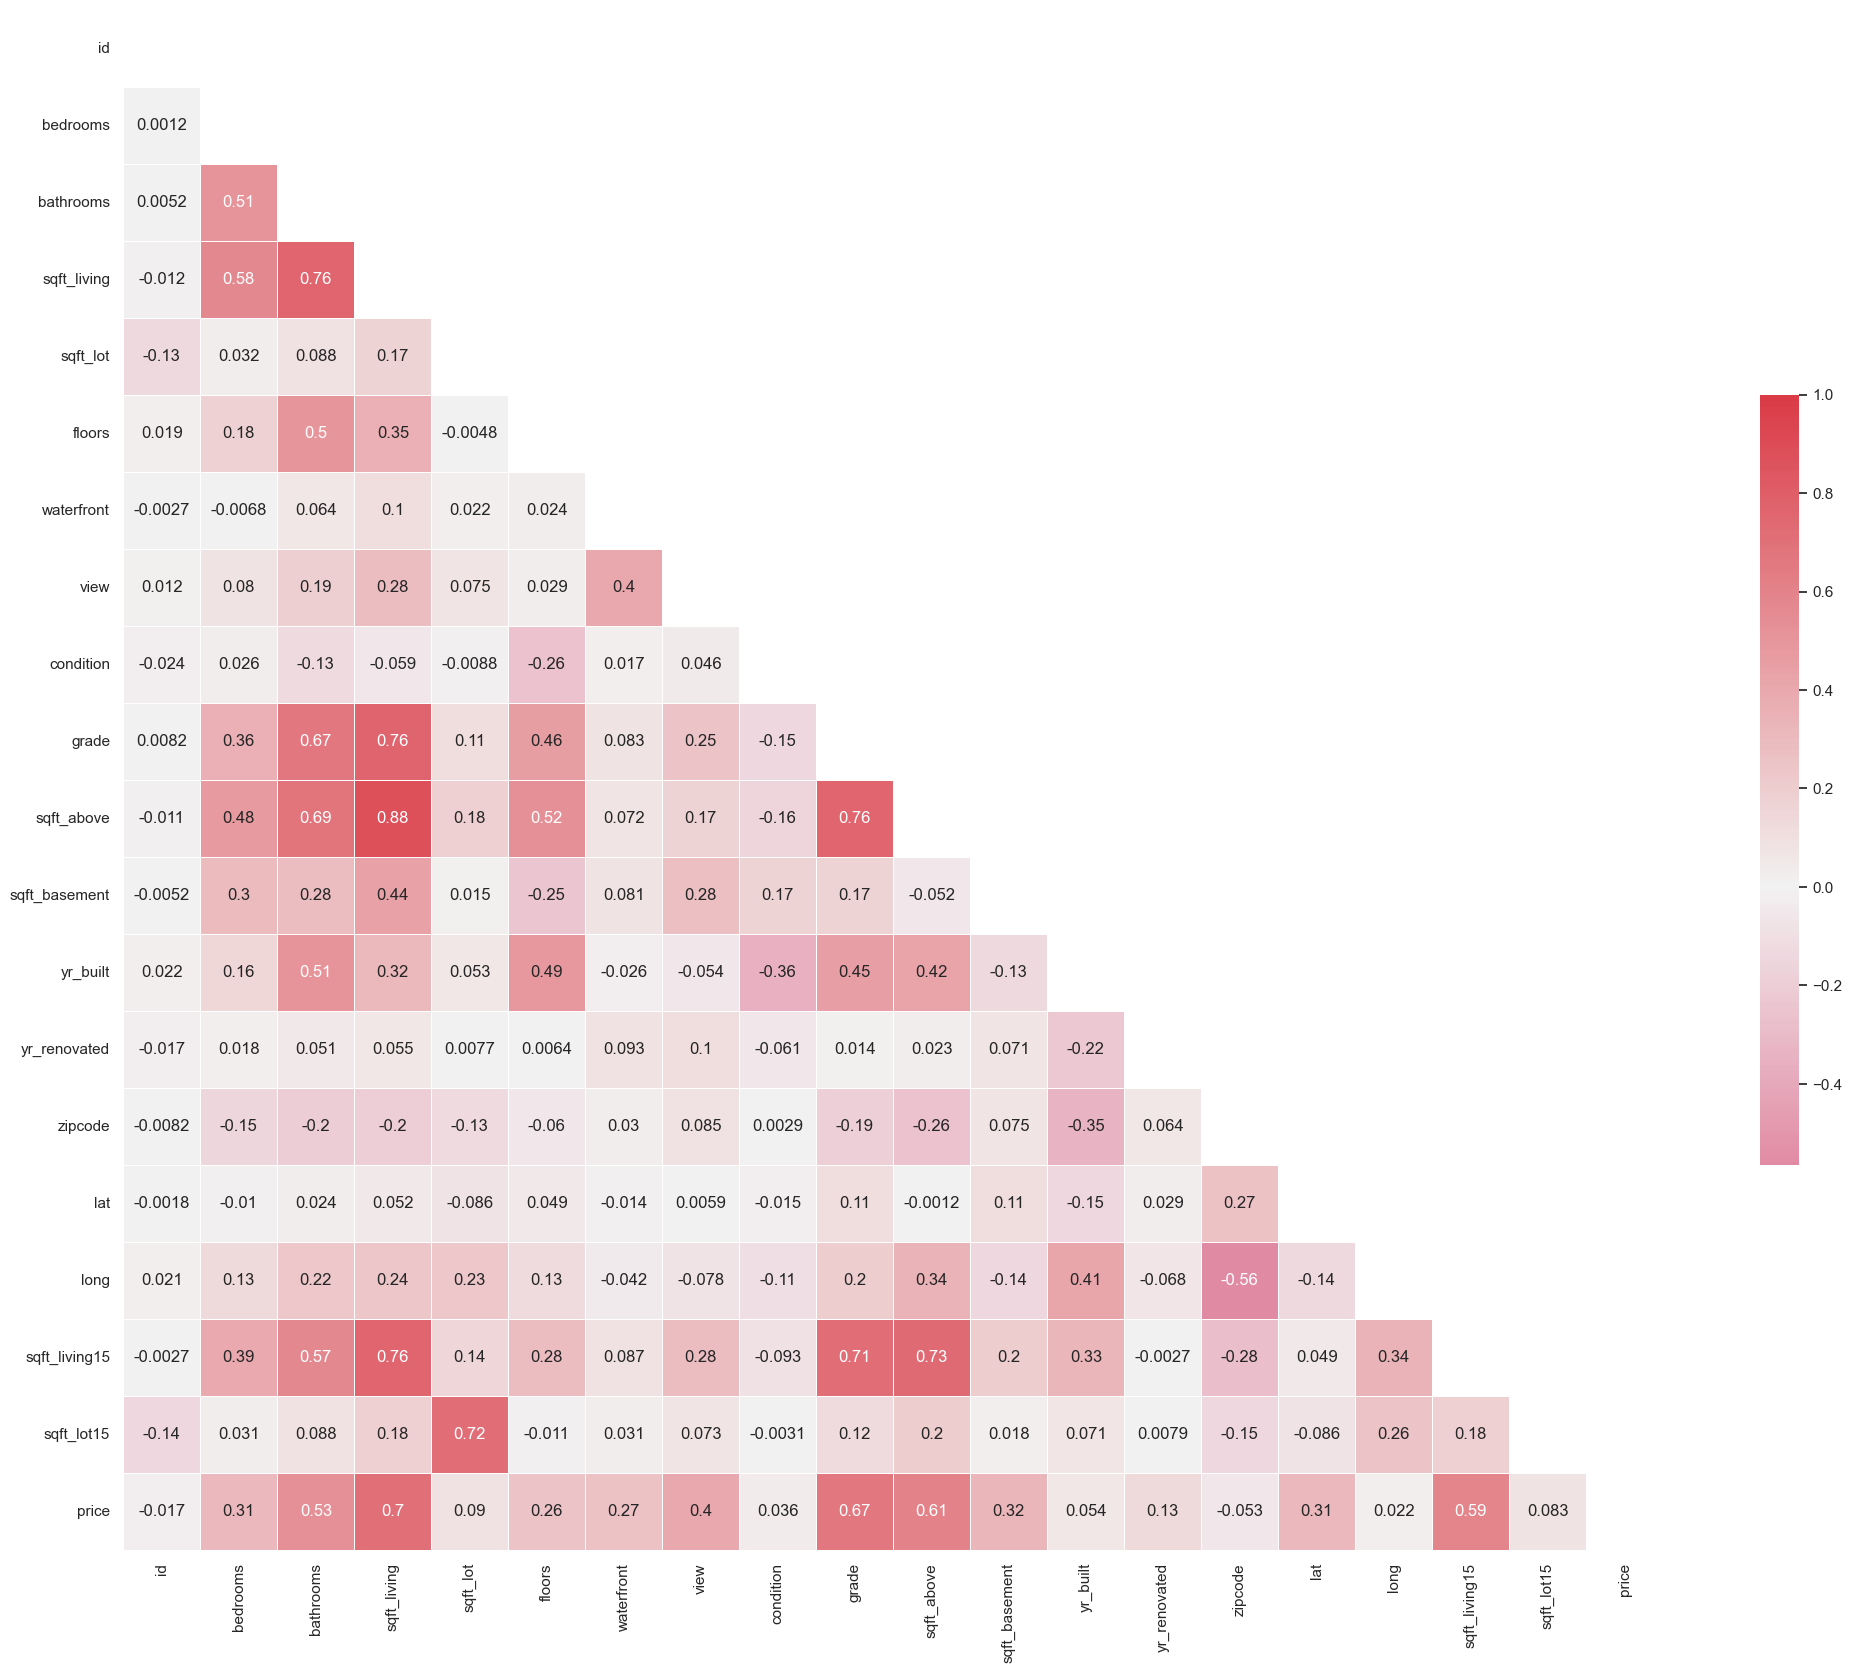

In [244]:
plt.rcParams['figure.figsize']=(25, 20)  # tamaño por defecto para los plots
def print_heatmap_corr(data:pd.DataFrame, annot:bool=True, cmap:str=None, 
                       mask:bool=True, save:bool=False, title:str=None)->None:
    
    '''
        Función que recibe un dataframe y devuelve la matriz de correlación en forma de mapa de color
        
        Parameters:
        -----------
        
        data: Dataset sobre el que queremos realizar la matriz de correlación
        annot: Si queremos mostrar el valor de la correlación en la matriz, default = True
        cmap: Paleta de colores que queremos usar para nuestro heatmap
        mask: Parámetro para mostrar solo la triangular inferior de la matriz de correlación
        save: Parámetro para salvar nuestro gráfico
        title: Título que queremos que lleve nuestro gráfico
    '''
    
    sns.set(style='white')     # estilo blanco hace que el fondo de la matriz sea transparente

    if mask: # Si mask es True
        mascara=np.triu(np.ones_like(data.corr(), dtype=bool))   # genera una mascara para tapar valores
    else:
        mascara = None # No aplicamos máscar

    if cmap: # Si le hemos pasado una paleta de colores
        c_map = sns.color_palette(cmap, as_cmap=True)
    else:
        c_map=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de colores por defecto


    p = sns.heatmap(data.corr(), # aplica el método corr() a nuestro dataset
            mask=mascara, # aplica la mascara
            cmap=c_map, # aplica la paleta de colores
            vmax=1, # para establecer el valor máximo de valores
            center=0, # establece el centro de la paleta de colores
            square=True,
            linewidth=0.5, # para aplicar borde a los cuadros de la matriz
            cbar_kws={'shrink': 0.5}, # mostrar leyenda de colores
            annot=annot # mostrar valores de la matriz
           )
    p.set_title(title, fontsize=20)
    
    if save:
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    

print_heatmap_corr(casas)

In [245]:
casas.drop("id", axis="columns", inplace=True) #no es relevante porque no aporta informacion acerca del precio
#casas.drop("lat", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona
casas.drop("long", axis="columns", inplace=True)#no es relevante porque todas las casas estan en la misma zona
casas.drop("zipcode", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona

In [246]:
# creo una columna que calcula los metros cuadrados totales incluyendo sotano, plantas y terreno sea o no  habitable
casas["sqft_total"]= sum(sum(casas["sqft_lot"] , casas["sqft_above"]) , casas["sqft_basement"])
casas.drop("sqft_lot", axis="columns", inplace=True)
casas.drop("sqft_above", axis="columns", inplace=True)
casas.drop("sqft_basement", axis="columns", inplace=True)

In [247]:
# creo una nueva columna last renovation, que junta las columnas year_built y year_renovated
casas["last_renovation"] = casas[["yr_built","yr_renovated"]].max(axis=1)
casas.drop("yr_built", axis="columns", inplace=True)
#casas.drop("yr_renovated", axis="columns", inplace=True)

In [248]:
#casas.drop("bedrooms", axis="columns", inplace=True) # esta información es no es util sabiendo los metros cuadrados
#casas.drop("bathrooms", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("condition", axis="columns", inplace=True) #condition no es utill sabiendo el grade
casas.drop("floors", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("waterfront", axis="columns", inplace=True) #esta informacion no es util pues el precio es equivalente con o sin waterfront
casas.drop("sqft_lot15", axis="columns", inplace=True)

In [249]:
casas.price.describe().T

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [250]:

def remove_outliers_from_dataframe(df, col, threshold: float = 2.9):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    intraquartile_range = q3 - q1
    fence_low  = q1 - threshold * intraquartile_range
    fence_high = q3 + threshold * intraquartile_range
    return df.loc[(df[col] > fence_low) & (df[col] < fence_high)]


casas=remove_outliers_from_dataframe(casas, "price")




In [251]:
casas.price.describe().T

count    2.114600e+04
mean     5.046626e+05
std      2.546916e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.458340e+05
75%      6.250000e+05
max      1.580000e+06
Name: price, dtype: float64

In [252]:
#casas.drop("last_renovation", axis="columns", inplace=True)
casas.drop("sqft_total", axis="columns", inplace=True)
casas.drop("view", axis="columns", inplace=True)
#casas.drop("sqft_living", axis="columns", inplace=True)

In [253]:
#reordeno las columnas para que price esté al final
precio = casas['price'] 
n= len(casas.columns)
casas.drop(labels=['price'], axis="columns",inplace = True)
casas.insert(n-1, 'price', precio)


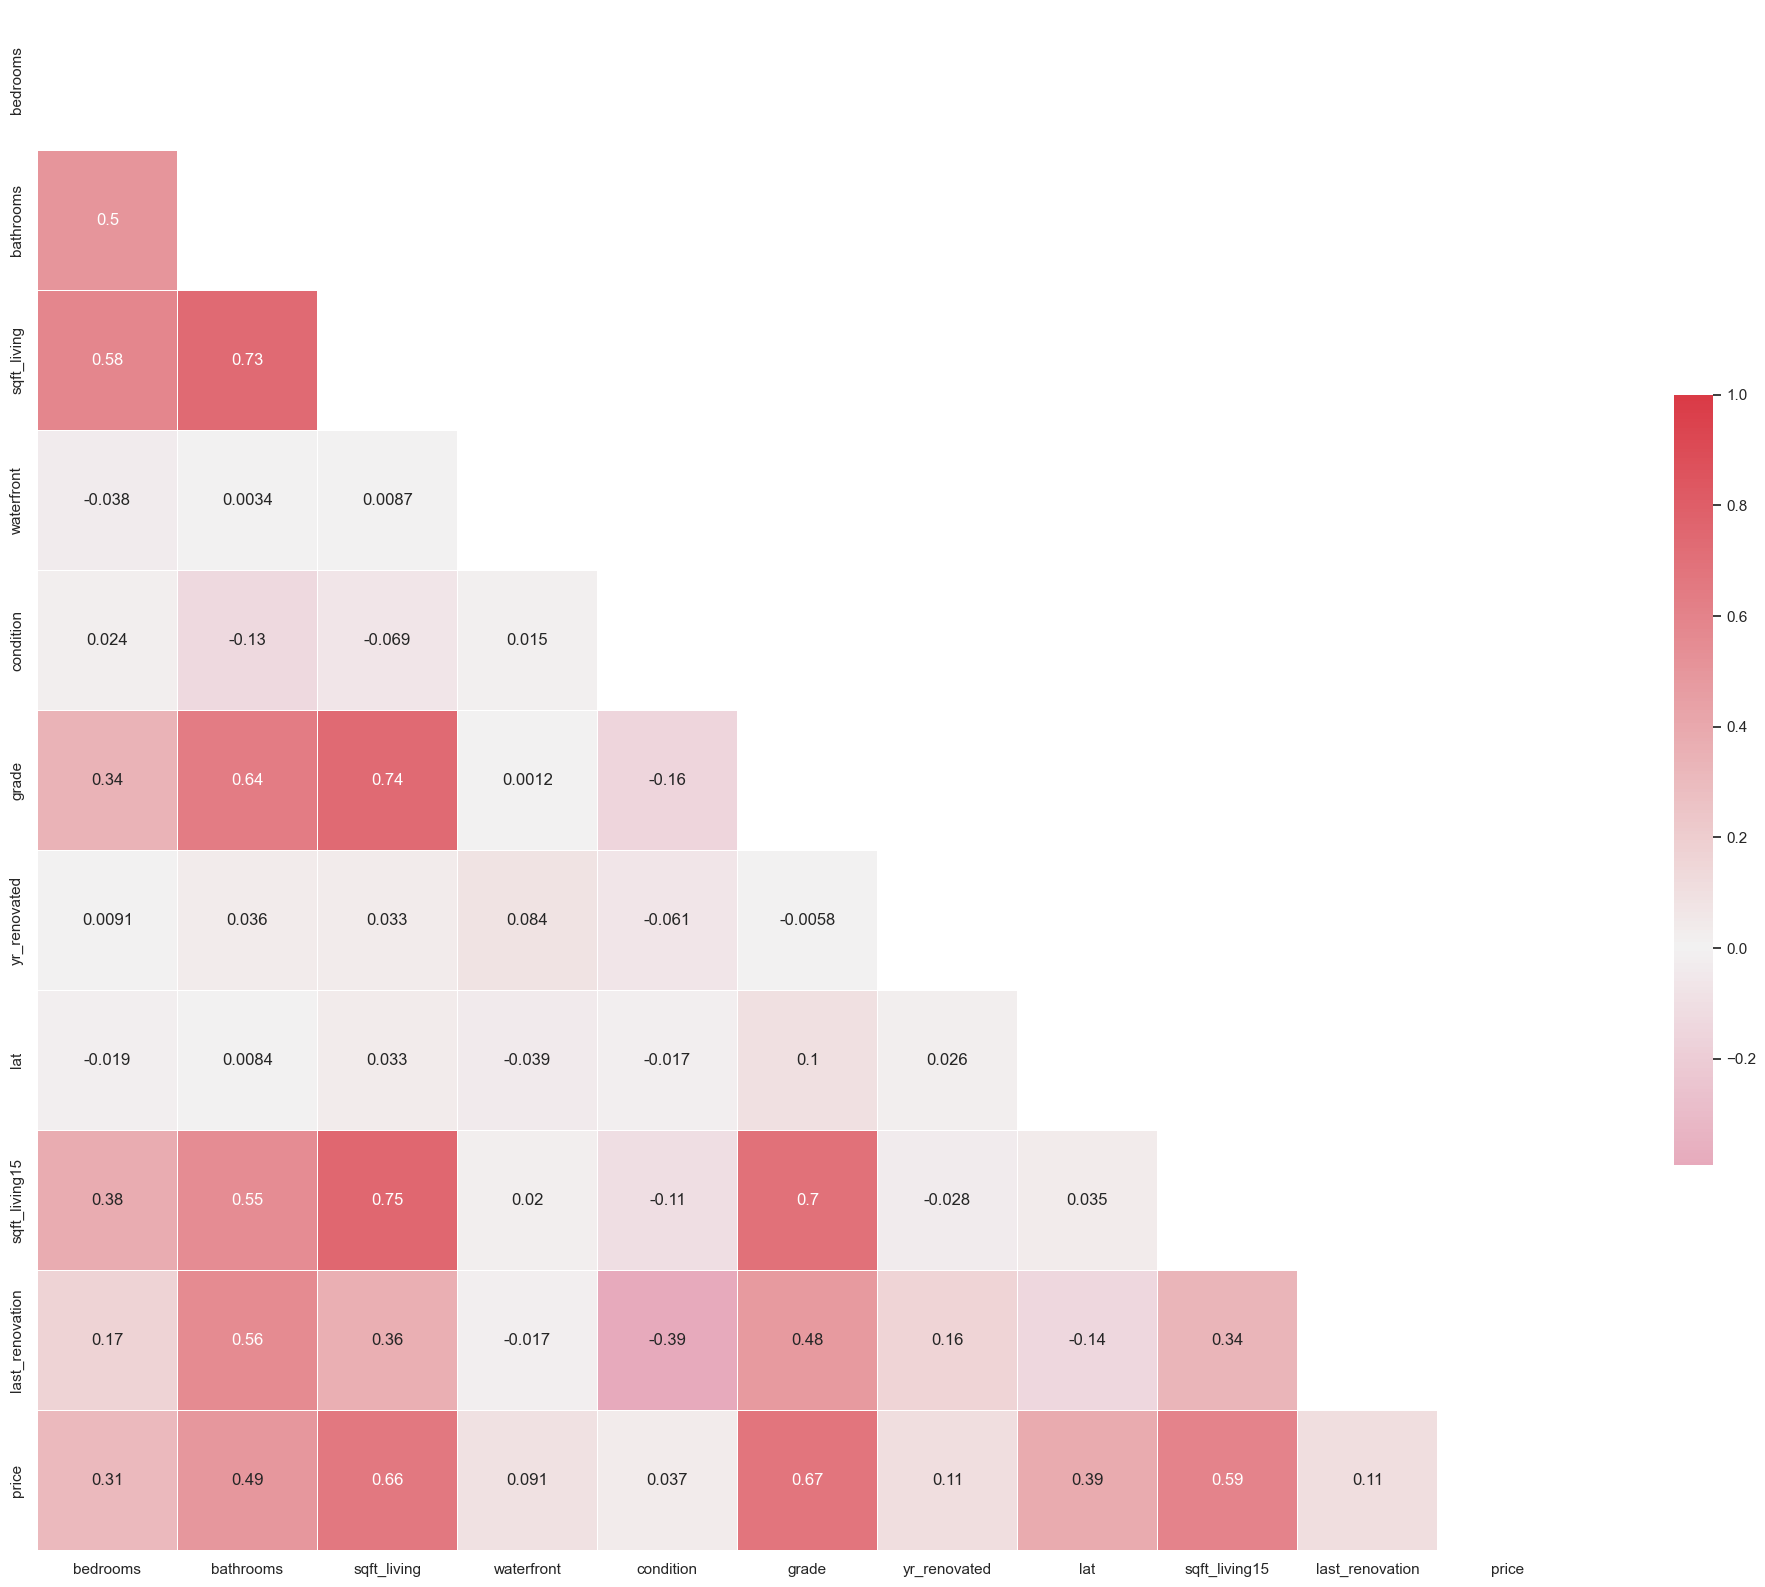

In [254]:
print_heatmap_corr(casas)

In [255]:
casas.corr()

,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,yr_renovated,lat,sqft_living15,last_renovation,price
bedrooms,1.000000,0.503110,0.583089,-0.037739,0.024147,0.338031,0.009134,-0.018827,0.379746,0.167404,0.311265
bathrooms,0.503110,1.000000,0.733892,0.003383,-0.134149,0.637934,0.036348,0.008365,0.547996,0.556278,0.492342
sqft_living,0.583089,0.733892,1.000000,0.008739,-0.069469,0.735514,0.032966,0.033128,0.751323,0.361949,0.661485
waterfront,-0.037739,0.003383,0.008739,1.000000,0.015368,0.001201,0.084406,-0.039302,0.020402,-0.017309,0.090551
condition,0.024147,-0.134149,-0.069469,0.015368,1.000000,-0.160630,-0.061282,-0.016919,-0.107440,-0.391874,0.037101
grade,0.338031,0.637934,0.735514,0.001201,-0.160630,1.000000,-0.005770,0.101585,0.695603,0.479576,0.669241
yr_renovated,0.009134,0.036348,0.032966,0.084406,-0.061282,-0.005770,1.000000,0.025884,-0.028118,0.160832,0.107256
lat,-0.018827,0.008365,0.033128,-0.039302,-0.016919,0.101585,0.025884,1.000000,0.035304,-0.139810,0.388517
sqft_living15,0.379746,0.547996,0.751323,0.020402,-0.107440,0.695603,-0.028118,0.035304,1.000000,0.336457,0.593394
last_renovation,0.167404,0.556278,0.361949,-0.017309,-0.391874,0.479576,0.160832,-0.139810,0.336457,1.000000,0.107251


In [256]:
X= casas.drop(["price","date"], axis="columns") 
y= casas["price"]

In [257]:
def plot_regression_model(x,y):
    
    x_const = add_constant(x) # add a constant to the model
    
    modelo = OLS(y, x_const).fit() # fit the model
    
    pred = modelo.predict(x_const) # make predictions
    
    print(modelo.summary());
    try:
        const = modelo.params[0] # create a variable with the value of the constant given by the summary
        coef = modelo.params[1] # create a variable with the value of the coef given by the summary

        x_l=np.linspace(x.min(), x.max(), 50) 
        y_l= coef*x_l + const # function of the line

        plt.figure(figsize=(10, 10));

        # plot the line
        plt.plot(x_l, y_l, label=f'{x.name} vs {y.name}={coef}*{x.name}+{const}');

        # data
        plt.scatter(x, y, marker='x', c='g', label=f'{x.name} vs {y.name}');

        plt.title('Regresion lineal')
        plt.xlabel(f'{x.name}')
        plt.ylabel(f'{y.name}')
        plt.legend()
        plt.show();
        return modelo
    except:
        print('No se puede imprimir la recta de regresión para modelos multivariable')
        plt.show();
        return modelo



In [258]:
"""
for c in X:
    plot_regression_model(X[c], y)

"""

'\nfor c in X:\n    plot_regression_model(X[c], y)\n\n'

In [259]:
multi = plot_regression_model(X,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     4807.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:16:42   Log-Likelihood:            -2.8069e+05
No. Observations:               21146   AIC:                         5.614e+05
Df Residuals:                   21135   BIC:                         5.615e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.228e+07   3.76e+05    -

<Figure size 1000x1000 with 0 Axes>

In [260]:
ln= LinearRegression()
ln.fit(X,y)





LinearRegression()

In [261]:
X_train ,X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2)

In [262]:


X_train.shape, X_test.shape, y_train.shape, y_test.shape


((16916, 10), (4230, 10), (16916,), (4230,))

In [263]:


sc = StandardScaler().fit(X_train)



In [264]:

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)


X_train.head()

,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,yr_renovated,lat,sqft_living15,last_renovation
19144,3,2.00,1540,0,4,7,0,47.3128,1500,1984
14057,5,3.00,2230,0,3,7,0,47.6404,1280,1913
5307,3,1.00,1960,0,4,7,0,47.7641,1850,1963
3121,4,2.75,2310,0,5,8,0,47.5502,1100,1908
11655,4,1.75,1530,0,4,7,0,47.6529,1650,1913


In [265]:
X_train_sc

array([[-0.38165702, -0.11214651, -0.58496909, ..., -1.76059811,
        -0.69844251,  0.37977536],
       [ 1.78482289,  1.25560429,  0.24806839, ...,  0.58549702,
        -1.03688359, -2.09051278],
       [-0.38165702, -1.47989731, -0.0779028 , ...,  1.47136994,
        -0.16001352, -0.35087324],
       ...,
       [-1.46489697, -1.47989731, -0.76606419, ..., -0.67348809,
        -0.52922197, -0.94235068],
       [-0.38165702,  0.22979119,  1.25012797, ...,  0.01759304,
         1.70141241,  0.34498257],
       [ 0.70158294, -0.11214651, -0.0779028 , ..., -1.63742095,
         0.00920702,  0.2406042 ]])

In [266]:

linreg=LinearRegression()
lasso=Lasso() # Favorece si nuestras betas son próximas a 0 L1
ridge=Ridge() # Favorece cuando hay sospechas de correlación entre caracteristicas L2
elastic=ElasticNet() # Mezcla de las anteriores, funciona bien cuando hay muchas características (L1+L2)


In [267]:

linreg.fit(X_train_sc, y_train)
lasso.fit(X_train_sc, y_train)
ridge.fit(X_train_sc, y_train)
elastic.fit(X_train_sc, y_train)


ElasticNet()

In [268]:
y.describe()

count    2.114600e+04
mean     5.046626e+05
std      2.546916e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.458340e+05
75%      6.250000e+05
max      1.580000e+06
Name: price, dtype: float64

In [269]:
from sklearn.metrics import mean_squared_error as mse

print(f' MSE linreg en train: {mse(y_train, linreg.predict(X_train_sc))}\n')
print(f' MSE linreg en test: {mse(y_test, linreg.predict(X_test_sc))}\n')
print(f' MSE lasso en train: {mse(y_train, lasso.predict(X_train_sc))}\n')
print(f' MSE lasso en test: {mse(y_test, lasso.predict(X_test_sc))}\n')
print(f' MSE ridge en train: {mse(y_train, ridge.predict(X_train_sc))}\n')
print(f' MSE ridge en test: {mse(y_test, ridge.predict(X_test_sc))}\n')
print(f' MSE ElasticNet en train: {mse(y_train, elastic.predict(X_train_sc))}\n')
print(f' MSE ElasticNet en test: {mse(y_test, elastic.predict(X_test_sc))}\n')

 MSE linreg en train: 19888074040.686592

 MSE linreg en test: 19504693532.272007

 MSE lasso en train: 19888074053.68335

 MSE lasso en test: 19504678091.286144

 MSE ridge en train: 19888074175.233055

 MSE ridge en test: 19504672303.623825

 MSE ElasticNet en train: 22795567776.237576

 MSE ElasticNet en test: 22210592801.781235



In [270]:
print(f' RMSE linreg en train: {mse(y_train, linreg.predict(X_train_sc), squared=False)}\n')
print(f' RMSE linreg en test: {mse(y_test, linreg.predict(X_test_sc), squared=False)}\n')
print(f' RMSE lasso en train: {mse(y_train, lasso.predict(X_train_sc), squared=False)}\n')
print(f' RMSE lasso en test: {mse(y_test, lasso.predict(X_test_sc), squared=False)}\n')
print(f' RMSE ridge en train: {mse(y_train, ridge.predict(X_train_sc), squared=False)}\n')
print(f' RMSE ridge en test: {mse(y_test, ridge.predict(X_test_sc), squared=False)}\n')
print(f' RMSE ElasticNet en train: {mse(y_train, elastic.predict(X_train_sc), squared=False)}\n')
print(f' RMSE ElasticNet en test: {mse(y_test, elastic.predict(X_test_sc), squared=False)}\n')

 RMSE linreg en train: 141025.0830196054

 RMSE linreg en test: 139659.20496792186

 RMSE lasso en train: 141025.08306568497

 RMSE lasso en test: 139659.14968696516

 RMSE ridge en train: 141025.08349663563

 RMSE ridge en test: 139659.1289662936

 RMSE ElasticNet en train: 150982.01143261263

 RMSE ElasticNet en test: 149032.18713345527



In [271]:


from sklearn.metrics import mean_absolute_error as mae

print(f' MAE linreg en train: {mae(y_train, linreg.predict(X_train_sc))}\n')
print(f' MAE linreg en test: {mae(y_test, linreg.predict(X_test_sc))}\n')
print(f' MAE lasso en train: {mae(y_train, lasso.predict(X_train_sc))}\n')
print(f' MAE lasso en test: {mae(y_test, lasso.predict(X_test_sc))}\n')
print(f' MAE ridge en train: {mae(y_train, ridge.predict(X_train_sc))}\n')
print(f' MAE ridge en test: {mae(y_test, ridge.predict(X_test_sc))}\n')
print(f' MAE ElasticNet en train: {mae(y_train, elastic.predict(X_train_sc))}\n')
print(f' MAE ElasticNet en test: {mae(y_test, elastic.predict(X_test_sc))}\n')


 MAE linreg en train: 102397.27814570963

 MAE linreg en test: 100115.83734095359

 MAE lasso en train: 102397.13197983561

 MAE lasso en test: 100115.70301825316

 MAE ridge en train: 102396.5853705578

 MAE ridge en test: 100115.16960066972

 MAE ElasticNet en train: 108739.54660089772

 MAE ElasticNet en test: 106802.31631997466



In [272]:

print(f' R2 linreg en train: {linreg.score(X_train_sc, y_train)}\n')
print(f' R2 linreg en test: {linreg.score(X_test_sc, y_test)}\n')
print(f' R2 lasso en train: {lasso.score(X_train_sc, y_train)}\n')
print(f' R2 lasso en test: {lasso.score(X_test_sc, y_test)}\n')
print(f' R2 ridge en train: {ridge.score(X_train_sc, y_train)}\n')
print(f' R2 ridge en test: {ridge.score(X_test_sc, y_test)}\n')
print(f' R2 ElasticNet en train: {elastic.score(X_train_sc, y_train)}\n')
print(f' R2 ElasticNet en test: {elastic.score(X_test_sc, y_test)}\n')



 R2 linreg en train: 0.6934080031012695

 R2 linreg en test: 0.6991796136462194

 R2 lasso en train: 0.6934080029009131

 R2 lasso en test: 0.699179851792147

 R2 ridge en train: 0.6934080010271184

 R2 ridge en test: 0.699179941055114

 R2 ElasticNet en train: 0.6485864528330288

 R2 ElasticNet en test: 0.6574465988546069



In [273]:
ln.score(X_train, y_train), ln.score(X_test, y_test)

(0.6933926284681036, 0.6993146909462318)